In [1]:
# packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as sci
import random

Matplotlib is building the font cache; this may take a moment.
/tmp/xpython_42/4122148159.py:5: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  import scipy.integrate as sci


All necessary parameters are listed below.

In [2]:
# dimension of the state (space)
n = 2
# limits of the state space
x_lim = np.array([[-2.,2.],[-4.,4.]]) 

# number of data points for training
d = int(5*1e4)
# time interval for discretization
dt = 0.02 

# number of observables, will be automatically initialized below
# M = 0 
# names of possible dictionaries
dictionaries = {'monom','simple'}
# choice of dictionary
dict_choice = 'monom'
# if dict_choice='monom', the degree of monomials is chosen here
monom_degree = 7

# starting point for training
x_0_train = np.array([0.2,0.3])
# starting point for testing
x_0_test = x_0_train 

# how many datapoints to display 
display_number_of_datapoints = 2000
dnod = display_number_of_datapoints # shorter name for convenience

Firstly, we take a look at our system, the Van der Pol oscillator. The dynamics are given by
\begin{align}
\dot{x}_1&=x_2\\
\dot{x}_2&=-x_1-\mu (x_{1}^{2}-1)x_2 +u,
\end{align}
with state $\mathbf{x}=[x_1,x_2]$, parameter $\mu=2$ and input $u$.

These dynamics are described trough the function vdp_dynamics. The function vdp_next describes the dynamic for the discretized system, i.e.
\begin{align}
x^{+}&=F(x).
\end{align}

Using this dynamic and a starting point x_0_train, we calculate and plot a trajectory.

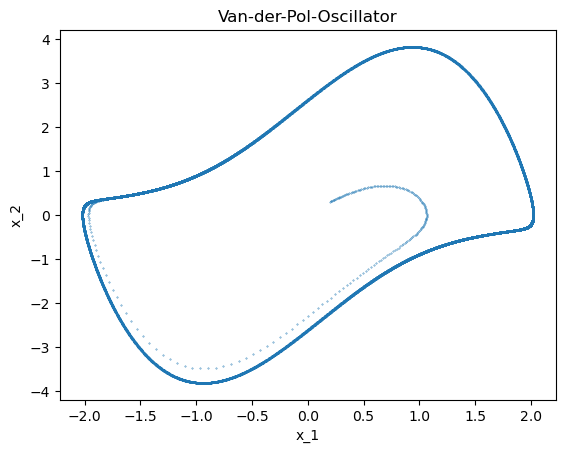

In [3]:
def vdp_dynamics(t,x,u=0):
    x_dot = np.array([x[1],(-x[0]-2*(x[0]**2-1)*x[1]+u)])
    return x_dot

def vdp_next(x,u=0,dt=dt):
    sol = sci.solve_ivp(vdp_dynamics,[0,dt],x,args=[u])
    return sol.y[:,-1]
    
# initialization of the trajectory x
x = np.zeros([n,d])
x[:,0] = x_0_train

# calculating the trajectory using the discretized dynamics
for i in range(1,d):
    x[:,i] = vdp_next(x[:,i-1])

# plot
def plot(x,title):
    plt.figure()    
    plt.scatter(x[0,:],x[1,:],s=0.1)
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.title(title)
    plt.show()

plot(x,'Van-der-Pol-Oscillator')

Random starting points:

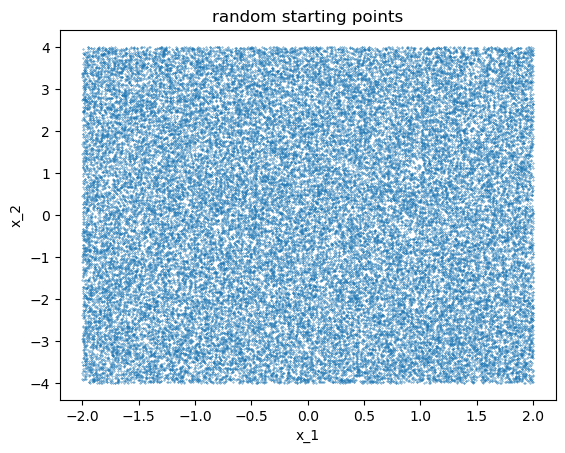

In [4]:
x_random = np.zeros([n,d])
for i in range(d):
    for j in range(n):
        x_random[j,i]=random.uniform(x_lim[j,0],x_lim[j,1])

plot(x_random,'random starting points')

In order to determine the Koopman operator, we need a dictionary $\{\varphi_1,\ldots,\varphi_M\}$. The observables are defined in the observables-function. The number $m$ of observables is set according to the chosen dictionary.

In [5]:
def observables(x,dict_choice=dict_choice,monom_degree=monom_degree):
    if dict_choice=='monom':
        g = np.array([1])
        for i in range(1,monom_degree+1):
            for j in range(i+1):
                g = np.append(g,(x[0]**(i-j))*(x[1]**j))
    elif dict_choice=='simple':
        g = np.array([1,x[0],x[1],x[0]*x[1],x[0]**2,x[1]**2])
    return g

# setting m, the number of observables
M = observables(np.zeros(n),dict_choice).size
print('number of observables: M='+str(M))

number of observables: M=36


Now, we compute $(K^{\Delta t}_d)^\top$:
\begin{align}
(K^{\Delta t}_d)^\top = (\Psi_X \Psi_X^\top)^{-1} \Psi_X \Psi_y^\top,
\end{align}
or, using the Moore-Penrose-inverse $\Psi_X^\dagger = \Psi_X^\top (\Psi_X\Psi_X^\top)^{-1}$,
\begin{align}
K_d^{\Delta t} =\Psi_Y\Psi_X^\dagger,
\end{align}
using the data matrices $\Psi_X,\Psi_Y\in\mathbb{R}^{M\times d}$:
\begin{align}
\Psi_X =\begin{pmatrix}
\psi_1(\mathbf{x}_1)&\ldots&\psi_1(\mathbf{x}_d)\\
\vdots & & \vdots\\
\psi_M(\mathbf{x}_1)&\ldots&\psi_M(\mathbf{x}_d)
\end{pmatrix}, \Psi_Y =
\begin{pmatrix}
\psi_1(F(\mathbf{x}_1))&\ldots&\psi_1(F(\mathbf{x}_d))\\
\vdots & & \vdots\\
\psi_M(F(\mathbf{x}_1))&\ldots&\psi_M(F(\mathbf{x}_d))
\end{pmatrix}.
\end{align}

In [6]:
X = np.zeros([M,d])
Y = np.zeros([M,d])
for i in range(d):
    X[:,i] = observables(x_random[:,i])
    Y[:,i] = observables(vdp_next(x_random[:,i]))

C = np.matmul(X,X.transpose())
A = np.matmul(X,Y.transpose())

K = np.matmul(np.linalg.inv(C),A).transpose()
K2 = np.matmul(Y,np.linalg.pinv(X))


The next step is the computation of a trajectory, starting at x_0_test, using the approximated Koopman operator.

In [7]:
x_koop = np.zeros([n,d])
x_koop[:,0] = x_0_test

for i in range(1,d):
    lift = observables(x_koop[:,i-1])
    fwd = np.matmul(K,lift)
    x_koop[:,i] = fwd[1:n+1]

Last, but not least, we plot our results.

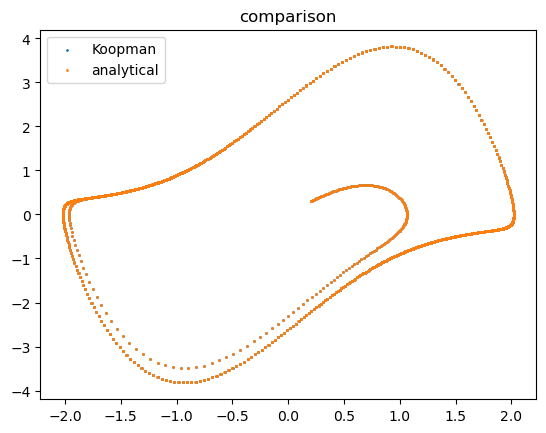

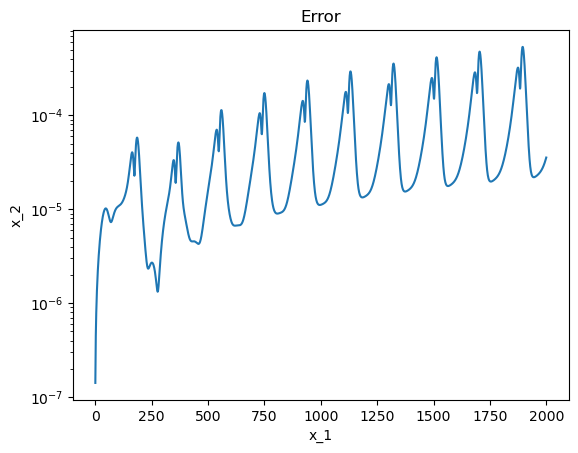

In [8]:
def plot_comp(x,y,dnod,title,xlabel='data A',ylabel='data B'):
    plt.figure()    
    plt.scatter(x[0,0:dnod],x[1,0:dnod],s=1,label=xlabel)
    plt.scatter(y[0,0:dnod],x[1,0:dnod],s=1,label=ylabel)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_comp(x_koop,x,dnod,'comparison','Koopman','analytical')

def euclidian_error(x_1,x_2,d=d):
    e = np.zeros([1,d])
    for i in range(d):
        e[0,i] = np.linalg.norm(x_1[:,i]-x_2[:,i])
    return e

def error_plot(e,dnod,title): 
    plt.figure()    
    plt.plot(np.arange(1,dnod),e[0,1:dnod])
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.semilogy()
    plt.title(title)
    plt.show()
    return

error = euclidian_error(x_koop, x)
error_plot(error, dnod, 'Error')